In [1]:
import scipy.integrate
import pints
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pints.toy

np.random.seed(123)

In [59]:
def load_wolf_moose_data(file_location):
    """Load the Wolves & Moose of Isle Royale data from csv file.
    
    Parameters
    ----------
    file_location : str
        path to the csv file containing the wolf-moose population numbers. The file should contain 
        the year in the first column, no. of moose in the second column, and the no. of wolves in the third column.

    Returns
    -------
    pandas.DataFrame
        Wolves & Moose of Isle Royale
    """
    names = ["year", "wolves", "moose", "calves", "senescent"]
    df = pd.read_csv(file_location, header=None, names=names)
    return df

dg = load_wolf_moose_data("wolf_moose_data1.csv").loc[:48]
# taking into account the depletion rate of the wolf population in the absence of prey
dg['modified time'] = (dg['year'] - 1959)* 40 
mod_times = dg['modified time'].values  
dg['adults'] = dg['moose'].values - dg['calves'].values - dg['senescent'].values
dg['f1'] = dg['calves'].values / 160
dg['f2'] = dg['adults'].values / 320
dg['f3'] = dg['senescent'].values / 160
observed_data = df[['f1', 'f2','f3', 'wolves']].values
init_calves, init_adults, init_senescent, init_wolves = dg['f1'].iloc[0], dg['f2'].iloc[0], dg['f3'].iloc[0], dg['wolves'].iloc[0]


In [66]:
print(dg['wolves'])

0     20
1     22
2     22
3     23
4     20
5     26
6     28
7     26
8     22
9     22
10    17
11    18
12    20
13    23
14    24
15    31
16    41
17    44
18    34
19    40
20    43
21    50
22    30
23    14
24    23
25    24
26    22
27    20
28    16
29    12
30    12
31    15
32    12
33    12
34    13
35    17
36    16
37    22
38    24
39    14
40    25
41    29
42    19
43    17
44    19
45    29
46    30
47    30
48    21
Name: wolves, dtype: int64


In [61]:
class LotkaVolterraModel(pints.ForwardModel):

    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`. """
        return 2

    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):
        k_1, k_2, k_3, d_1, d_3, l_12, l_13, l_32, F  = parameters

        def dy(tau, state):
            f_1, f_2, f_3, f_4 = state

            G = ((d_1 + d_3) * (1 - np.exp(-d_1*f_1 - d_3*f_3)))/((d_1*f_1 + d_3*f_3) * (1-np.exp(-d_1-d_3)))
            
            df_1 = k_1*((1-(f_1+f_2+f_3)/F)*(-f_1+l_12*f_2 + l_13*f_3)-(1-3/F)*(l_12+l_13-1)*f_1*f_4*G)
            df_2 = k_2*(f_1-f_2)
            df_3 = k_3*(l_32*f_2 -f_3 -(l_32-1)*f_3*f_4*G)
            df_4 = f_4*(-1+(1 - np.exp(-d_1*f_1 - d_3*f_3))/(1-np.exp(-d_1-d_3)))
            
            return (df_1, df_2, df_3, df_4)

        initial_condition = np.asarray([np.log(init_calves), np.log(init_adults), np.log(init_senescent), np.log(init_wolves) ])

        res = scipy.integrate.solve_ivp(
            dy,
            (0, max(mod_times)),
            initial_condition,
            t_eval=mod_times )
        
        return res.y.T

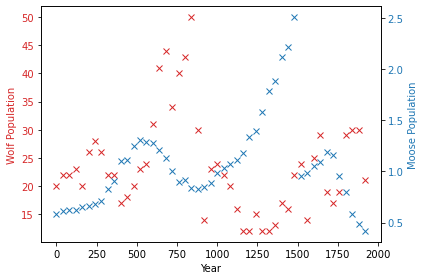

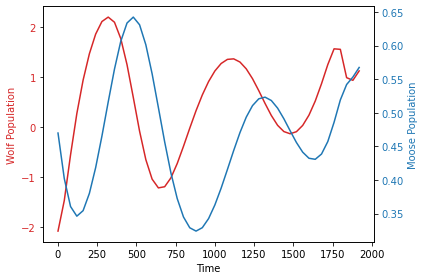

In [69]:
m = LotkaVolterraModel()

# Plot wolf and moose populations
fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, dg['wolves'], 'x', color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, (dg['f1'].values + dg['f2'].values +dg['f3'].values)/3, 'x', color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

# Make a model object and run a simulation at arbitrary parameter values
# times1 = np.linspace(0, 20, 100)
params = [0.0125, 0.00075, 0.006, 2.0, 2.4, 2.0, 1.0, 16.0, 8.0]
#init_wolves, init_moose = 5, 30
#df['wolf'].iloc[0], df['moose'].iloc[0]
y = m.simulate(params, mod_times)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, y[:, 0], color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, y[:, 1], color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()